## ABSTRACT

### Resumen

El dataset analizado corresponde a una serie de noticias, tanto reales como falsas, escritas en lengua inglesa. Cabe destacar que las noticias presentes en el dataset ya cuentan con etiquetas del tipo 'real' o 'falsa' (real/fake).

### Objetivo

El objetivo del presente análisis es realizar un preprocesamiento de la data actualmente en lenguaje natural, eliminando o modificando palabras para lograr una mayor efectividad a la hora de procesar modelos de clasificación, e implementar éstos logrando entrenarlos para luego poder identificar nuevas noticias falsas, con un cierto nivel de confianza.

### Contexto Comercial

El proyecto es de índole investigativa, con posible aplicación en periodismo, ciberseguridad o política.

In [1]:
# Librerías
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, recall_score
from sklearn.linear_model import PassiveAggressiveClassifier

# Descargar recursos necesarios de nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [3]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [4]:
df

,Unnamed: 0,title,texto,sentimiento
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [5]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

In [6]:
df = df.set_index('Unnamed: 0')

In [7]:
df.shape

(6335, 3)

In [8]:
df.head()

,title,texto,sentimiento
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [9]:
# Contar cuantas noticias reales y fakes hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?

df['sentimiento'].value_counts(normalize=True)

sentimiento
REAL    0.500552
FAKE    0.499448
Name: proportion, dtype: float64

In [10]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

df_sample, _ = train_test_split(df, train_size=1000, stratify=df["sentimiento"], random_state=42)

print(df_sample.shape)
df_sample['sentimiento'].value_counts(normalize=True)

(1000, 3)


sentimiento
REAL    0.501
FAKE    0.499
Name: proportion, dtype: float64

In [11]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)

df_sample['sentimiento'] = df_sample['sentimiento'].map({'FAKE': 0, 'REAL': 1})
df_sample['sentimiento'].unique()

array([1, 0], dtype=int64)

### A continuación, se realiza un prepocesamiento del texto, eliminando palabras que generan ruido en el análisis, luego filtrando por tipo de palabra (sustantivo, adjetivo y verbo) y trayendolas a su raíz etimológica.

In [12]:
stop_words = set(stopwords.words('english'))

def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words and token.pos_ in {"NOUN", "ADJ", "VERB"}]
    return " ".join(tokens)

In [13]:
# Aplicar preprocesamiento
df_sample['texto_procesado'] = df_sample['texto'].apply(preprocesar_texto)
df_sample.head()

,title,texto,sentimiento,texto_procesado
Unnamed: 0,,,,
1627,The Democratic Debate Clock: Which Issues Got ...,The Democratic Debate Clock: Which Issues Got ...,1,democratic debate clock issue get time democra...
2570,Uncovered audio: Hillary was ‘adamantly agains...,**Want FOX News First in your inbox every day?...,1,want news inbox day sign buzz cut uncovered au...
6985,Carrier battle group never planned to call at ...,Carrier battle group never planned to call at ...,0,battle group plan call spanish port russian ge...
6027,Do You Know What It Means To Be An Introvert?,Leave a reply \nKate Bartolotta – In this day ...,0,leave reply kate bartolotta day age constant u...
8319,"This is tyranny not democracy, says party with...","This is tyranny not democracy, says party with...",0,tyranny democracy say party single mp ukip ass...


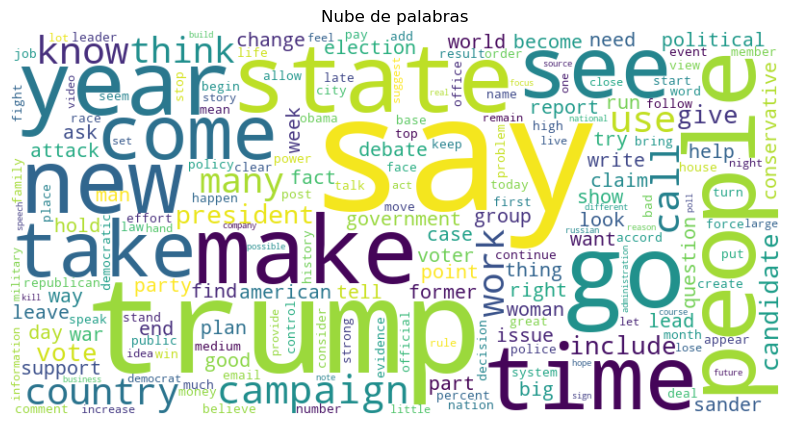

In [14]:
# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df_sample['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
     N-gram  Frecuencia
0       say        4792
1     trump        3310
2     state        1741
3    people        1676
4        go        1610
5      year        1594
6      make        1579
7      time        1286
8  campaign        1241
9      take        1227


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

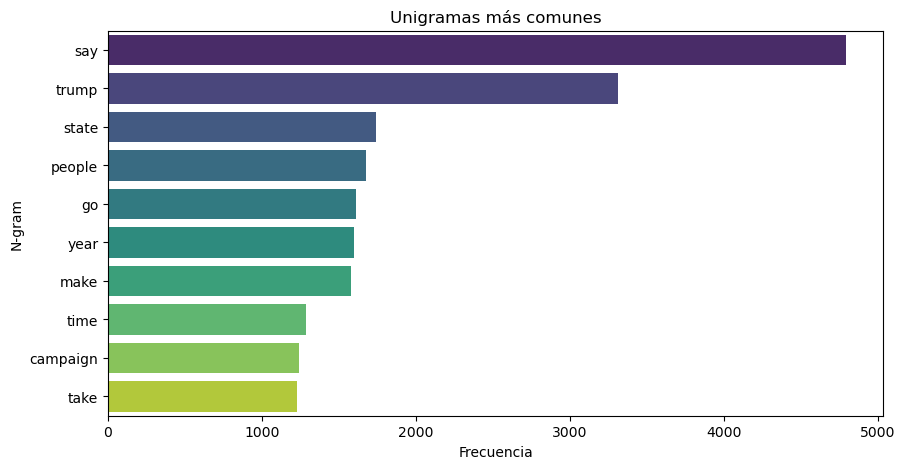


Bigramas más comunes:
                   N-gram  Frecuencia
0          foreign policy         174
1               last year         160
2               trump say         157
3               last week         153
4  presidential candidate         147
5                year old         140
6           islamic state         134
7            official say         122
8   presidential election         111
9        democratic party         106


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

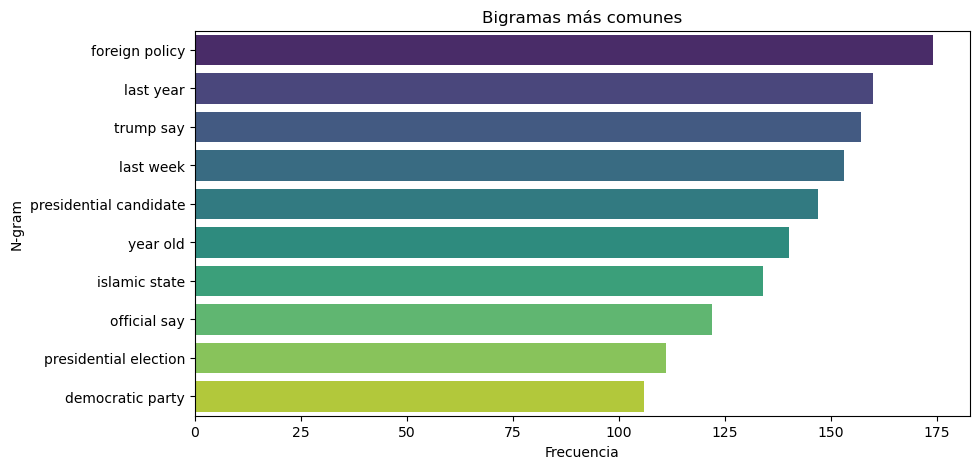


Trigramas más comunes:
                              N-gram  Frecuencia
0                     case case case          64
1  republican presidential candidate          39
2               private email server          31
3                  use private email          28
4            press contribute report          25
5                  black life matter          24
6     democratic national convention          24
7    republican presidential nominee          24
8           law enforcement official          23
9        associated press contribute          20


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

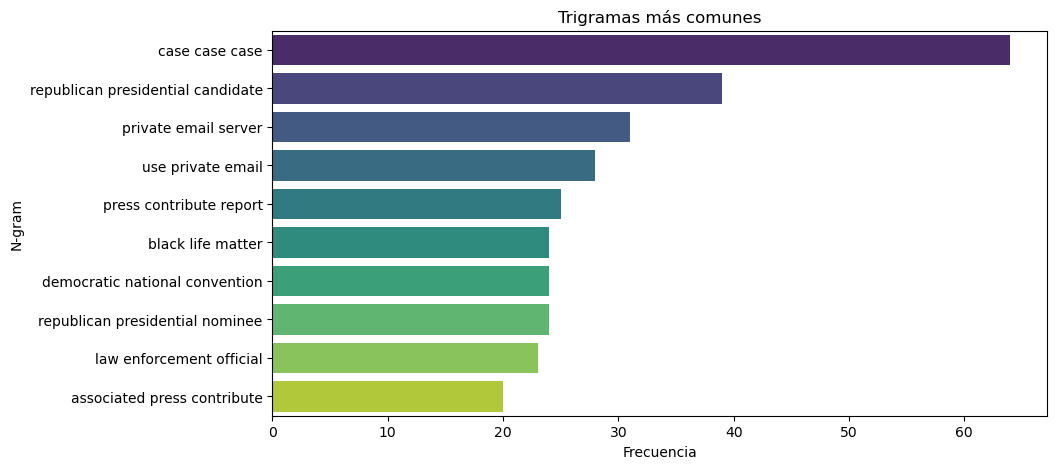

In [15]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_sample['texto_procesado'], 1)
bigrams = get_top_ngrams(df_sample['texto_procesado'], 2)
trigrams = get_top_ngrams(df_sample['texto_procesado'], 3)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

### A continuación, analizamos las palabras, o conjuntos de palabras, más comunes para cada eitqueta real/fake.

Fake: 

Unigramas más comunes:
     N-gram  Frecuencia
0       say        1009
1     trump        1007
2    people         794
3        go         652
4      make         619
5      year         617
6  election         607
7      time         575
8     state         563
9      take         504


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

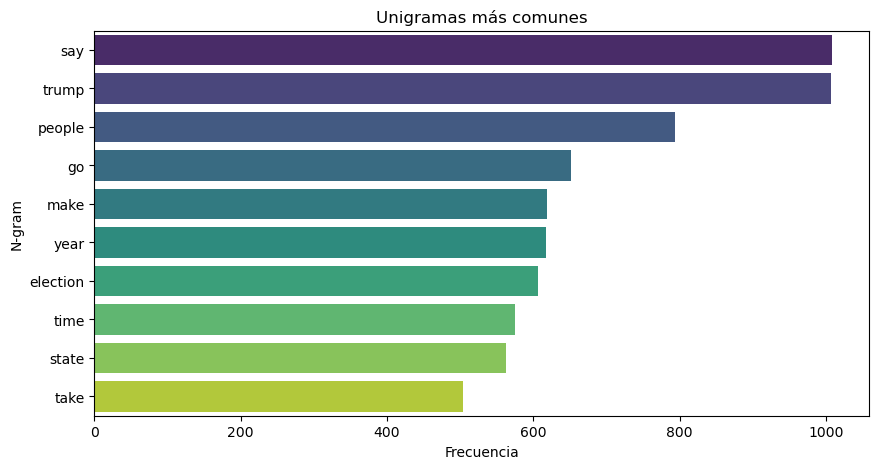


Bigramas más comunes:
                  N-gram  Frecuencia
0              case case          65
1  presidential election          65
2         foreign policy          63
3               year old          62
4        american people          57
5              last year          53
6              trump win          49
7           election day          48
8       democratic party          39
9         electoral vote          39


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

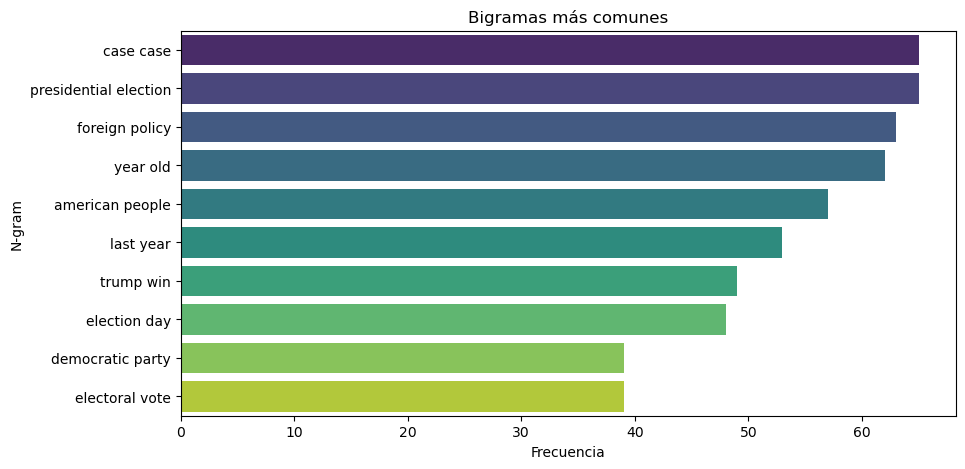


Trigramas más comunes:
                           N-gram  Frecuencia
0                  case case case          64
1            private email server          16
2               black life matter          14
3  comment unregistered commenter          14
4              get electoral vote          14
5       link comment unregistered          14
6         activation infowar life          12
7                brain force next          12
8         flip switch supercharge          12
9           force next generation          12


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

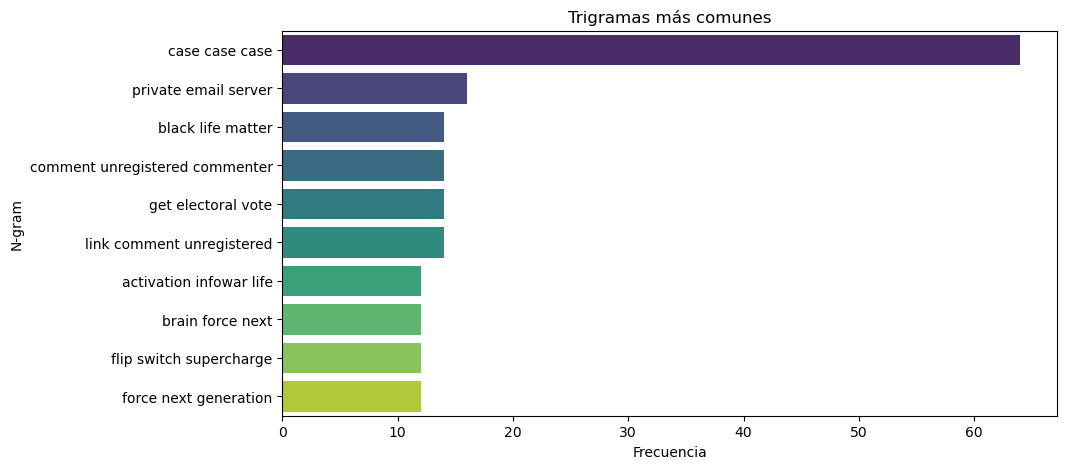

Real: 

Unigramas más comunes:
      N-gram  Frecuencia
0        say        3783
1      trump        2303
2      state        1178
3       year         977
4       make         960
5         go         958
6   campaign         898
7     people         882
8        get         771
9  candidate         724


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

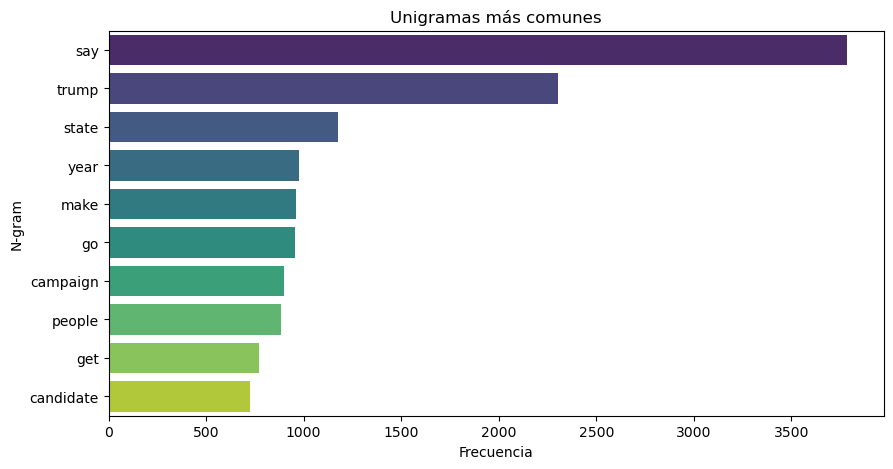


Bigramas más comunes:
                   N-gram  Frecuencia
0               last week         131
1               trump say         131
2           islamic state         120
3          foreign policy         111
4  presidential candidate         108
5               last year         107
6            official say         102
7            sex marriage          89
8                year old          78
9             health care          69


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

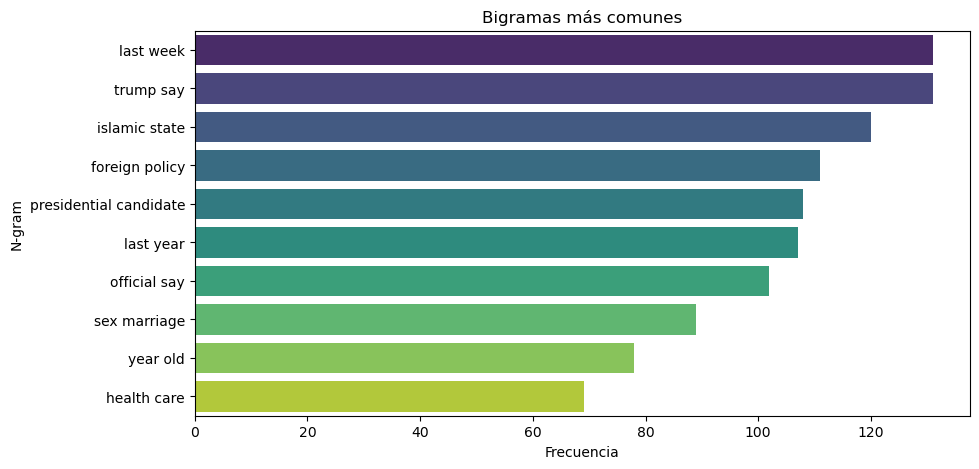


Trigramas más comunes:
                              N-gram  Frecuencia
0  republican presidential candidate          30
1            press contribute report          25
2        associated press contribute          20
3  democratic presidential candidate          17
4     democratic national convention          16
5              third party candidate          16
6                  use private email          16
7             issue marriage license          15
8               private email server          15
9           law enforcement official          14


C:\Users\Guillermo Edwards\AppData\Local\Temp\ipykernel_9744\3227380754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo Edwards\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Guillermo E

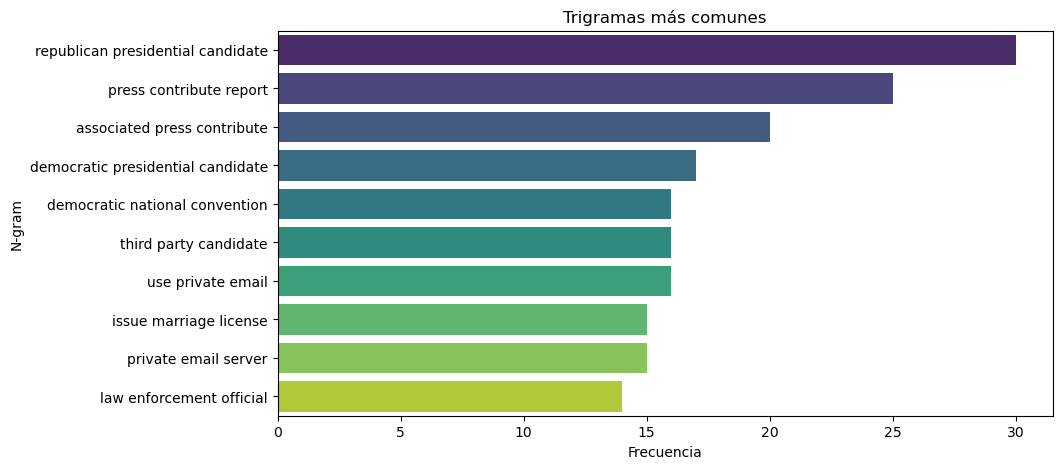

In [16]:
# N-grams: Fake/Real

Fake_df = df_sample.loc[df_sample['sentimiento']==0, 'texto_procesado']
Real_df = df_sample.loc[df_sample['sentimiento']==1, 'texto_procesado']

for label, df in [('Fake', Fake_df), ('Real', Real_df)]:
    print(f'{label}: \n')
       
    unigrams = get_top_ngrams(df, 1)
    bigrams = get_top_ngrams(df, 2)
    trigrams = get_top_ngrams(df, 3)
    
    print("Unigramas más comunes:")
    print(unigrams)
    plot_ngrams(unigrams, "Unigramas más comunes")
    
    print("\nBigramas más comunes:")
    print(bigrams)
    plot_ngrams(bigrams, "Bigramas más comunes")
    
    print("\nTrigramas más comunes:")
    print(trigrams)
    plot_ngrams(trigrams, "Trigramas más comunes")

In [17]:
# Separar datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(df_sample['texto_procesado'], df_sample['sentimiento'], test_size=0.25, stratify=df_sample["sentimiento"], random_state=42)

### Ya teniendo una primera mirada al comportamiento de los conjuntos de palabras más comunes versus las etiquetas, luego de un preprocesamiento previo, aplicamos dos modelos a continuación para poder entrenar y predecir:
- El primero unirá, mediante vectorización, las frecuencias de las palabras/conjuntos con cada etiqueta, obteniendo así una matriz numérica.
- El segundo obtendrá, mediante la data numérica obtenido por el primero, una función de etiquetado basada en probabilidades bayesianas. 

In [18]:
combinaciones = {(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)}
rank = []

for (n, m) in combinaciones:
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(n,m))),
    ('clf', MultinomialNB())
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    recall = recall_score(y_test, y_pred, average='macro')
    rank.append(((n,m), recall))
    
    print(f'Para {n,m}: \n') 
    print("Recall:", recall)
    print(classification_report(y_test, y_pred))

rank.sort(key=lambda x: x[1], reverse=True)
resultado_1 = rank[0]

print(rank)

Para (2, 3): 

Recall: 0.752
              precision    recall  f1-score   support

           0       0.98      0.51      0.67       125
           1       0.67      0.99      0.80       125

    accuracy                           0.75       250
   macro avg       0.83      0.75      0.74       250
weighted avg       0.83      0.75      0.74       250

Para (1, 2): 

Recall: 0.664
              precision    recall  f1-score   support

           0       1.00      0.33      0.49       125
           1       0.60      1.00      0.75       125

    accuracy                           0.66       250
   macro avg       0.80      0.66      0.62       250
weighted avg       0.80      0.66      0.62       250

Para (3, 3): 

Recall: 0.716
              precision    recall  f1-score   support

           0       0.86      0.52      0.65       125
           1       0.66      0.91      0.76       125

    accuracy                           0.72       250
   macro avg       0.76      0.72      0.

### A continuación, modelamos de forma alternativa, con un preprocesamiento más simple, eliminando las palabras ruido y aquellas que se repiten en un alto porcentaje de la documentación, y entrenando la data con un modelo basado en margenes en vez de probabilidades.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df_sample['texto'], df_sample['sentimiento'], test_size=0.25, stratify=df_sample["sentimiento"], random_state=42)
rank = []


for (n, m) in combinaciones:
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(n,m), stop_words='english', max_df =0.9)),
    ('pac', PassiveAggressiveClassifier(max_iter=50))
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    recall = recall_score(y_test, y_pred, average='macro')
    rank.append(((n,m), recall))
    
    print(f'Para {n,m}: \n') 
    print("Recall:", recall)
    print(classification_report(y_test, y_pred))

rank.sort(key=lambda x: x[1], reverse=True)
resultado_2 = rank[0]
print(rank)

Para (2, 3): 

Recall: 0.864
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       125
           1       0.83      0.91      0.87       125

    accuracy                           0.86       250
   macro avg       0.87      0.86      0.86       250
weighted avg       0.87      0.86      0.86       250

Para (1, 2): 

Recall: 0.876
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       125
           1       0.87      0.89      0.88       125

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250

Para (3, 3): 

Recall: 0.8240000000000001
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       125
           1       0.78      0.90      0.84       125

    accuracy                           0.82       250
   macro avg       0.83     

In [20]:
resultados = {
    "resultado_1": resultado_1,
    "resultado_2": resultado_2
}

mejor_resultado = max(resultados, key=lambda x: resultados[x][1])
mejor_valor = resultados[mejor_resultado][1]

print(f"Mejor resultado: {mejor_resultado} con valor {mejor_valor}")

Mejor resultado: resultado_2 con valor 0.88


### Conclusión

Se probaron y evaluaron distintas alternativas de modelamiento, con distinto preprocesamiento de texto, y se obtuvo un evidente mejor resultado al utilizar un preprocesamiento simple y un modelo de predicción basado en márgenes (PassiveAgressiveClassifier).

Cabe destacar que este último modelo se evaluó de dos maneras, una mediante un pipeline (método de modelamiento más estandarizado) y, de manera alternativa, con un método manual. Éstas dos alternativas entregaron resultados diferentes, siendo mejor el estandarizado (esto por una estructura interna más eficiente).